# Testing

In [1]:
# Prediction margin: the only parameter to set. Recommended: margin in {5, 10, 15, 20} (aka 0.5, 1, 1.5, 2 seconds)
margin = 5

## Import libraries and define utility functions

In [2]:
import pandas as pd
import numpy as np
import sys
import random
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from math import floor
from tensorflow import keras
from tensorflow.keras import layers, callbacks

In [3]:
mean = lambda l: sum(l) / len(l)

#### Set up global variables

In [4]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [5]:
models_path = "models_" + str(margin) + "/"
results_path = "results_" + str(margin) + "/"
threshold_path = "threshold_" + str(margin) + "/"
seeds = [100, 200, 300]

In [6]:
w5_features_no_diff = [
 'Gz_mean_w5',
 'Ax_mean_w5',
 'Ay_mean_w5',
 'Gz_std_w5',
 'Ax_std_w5',
 'Ay_std_w5',
 'Gz_min_w5',
 'Ax_min_w5',
 'Ay_min_w5',
 'Gz_max_w5',
 'Ax_max_w5',
 'Ay_max_w5'
]

w5_features_diff = [
 'differencing_Gz_mean_w5',
 'differencing_Ax_mean_w5',
 'differencing_Ay_mean_w5',
 'differencing_Gz_std_w5',
 'differencing_Ax_std_w5',
 'differencing_Ay_std_w5',
 'differencing_Gz_min_w5',
 'differencing_Ax_min_w5',
 'differencing_Ay_min_w5',
 'differencing_Gz_max_w5',
 'differencing_Ax_max_w5',
 'differencing_Ay_max_w5',
]

w10_features_no_diff = [
 'Gz_mean_w10',
 'Ax_mean_w10',
 'Ay_mean_w10',
 'Gz_std_w10',
 'Ax_std_w10',
 'Ay_std_w10',
 'Gz_min_w10',
 'Ax_min_w10',
 'Ay_min_w10',
 'Gz_max_w10',
 'Ax_max_w10',
 'Ay_max_w10'
]

w10_features_diff = [
 'differencing_Gz_mean_w10',
 'differencing_Ax_mean_w10',
 'differencing_Ay_mean_w10',
 'differencing_Gz_std_w10',
 'differencing_Ax_std_w10',
 'differencing_Ay_std_w10',
 'differencing_Gz_min_w10',
 'differencing_Ax_min_w10',
 'differencing_Ay_min_w10',
 'differencing_Gz_max_w10',
 'differencing_Ax_max_w10',
 'differencing_Ay_max_w10'
]

w15_features_no_diff = [
 'Gz_mean_w15',
 'Ax_mean_w15',
 'Ay_mean_w15',
 'Gz_std_w15',
 'Ax_std_w15',
 'Ay_std_w15',
 'Gz_min_w15',
 'Ax_min_w15',
 'Ay_min_w15',
 'Gz_max_w15',
 'Ax_max_w15',
 'Ay_max_w15'
]

w15_features_diff = [
 'differencing_Gz_mean_w15',
 'differencing_Ax_mean_w15',
 'differencing_Ay_mean_w15',
 'differencing_Gz_std_w15',
 'differencing_Ax_std_w15',
 'differencing_Ay_std_w15',
 'differencing_Gz_min_w15',
 'differencing_Ax_min_w15',
 'differencing_Ay_min_w15',
 'differencing_Gz_max_w15',
 'differencing_Ax_max_w15',
 'differencing_Ay_max_w15'
]

w20_features_no_diff = [
 'Gz_mean_w20',
 'Ax_mean_w20',
 'Ay_mean_w20',
 'Gz_std_w20',
 'Ax_std_w20',
 'Ay_std_w20',
 'Gz_min_w20',
 'Ax_min_w20',
 'Ay_min_w20',
 'Gz_max_w20',
 'Ax_max_w20',
 'Ay_max_w20'
]

w20_features_diff = [
 'differencing_Gz_mean_w20',
 'differencing_Ax_mean_w20',
 'differencing_Ay_mean_w20',
 'differencing_Gz_std_w20',
 'differencing_Ax_std_w20',
 'differencing_Ay_std_w20',
 'differencing_Gz_min_w20',
 'differencing_Ax_min_w20',
 'differencing_Ay_min_w20',
 'differencing_Gz_max_w20',
 'differencing_Ax_max_w20',
 'differencing_Ay_max_w20',
]

features = {
    "all_features": w5_features_no_diff + w10_features_no_diff + w15_features_no_diff + w20_features_no_diff + w5_features_diff + w10_features_diff + w15_features_diff + w20_features_diff + ['label'], 
    "w5_features": w5_features_no_diff + w5_features_diff + ['label'], 
    "w10_features": w10_features_no_diff + w10_features_diff + ['label'], 
    "w15_features": w15_features_no_diff + w15_features_diff + ['label'], 
    "w20_features": w20_features_no_diff + w20_features_diff + ['label'], 
    "no_diff_features": w5_features_no_diff + w10_features_no_diff + w15_features_no_diff + w20_features_no_diff + ['label'], 
    "diff_features": w5_features_diff + w10_features_diff + w15_features_diff + w20_features_diff + ['label']
}

#### Set up global variables

In [7]:
f_headers = r'data/headers.txt'
f_acc = r'data/test-raw/dataset_acc.csv'
f_pos = r'data/test-raw/dataset_pos.csv'
f_labels = r'data/test-raw/labels.csv'

#### Load utilities 

In [8]:
with open('data/utils/scaler_' + str(margin) + '.bin', 'rb') as handle:
    scaler = pickle.load(handle)
with open('data/utils/fixed_orient_' + str(margin) + '.bin', 'rb') as handle:
    fixed_orient = pickle.load(handle)
with open('data/utils/fixed_pos_' + str(margin) + '.bin', 'rb') as handle:
    fixed_pos = pickle.load(handle)
with open('data/utils/differencing_dict_' + str(margin) + '.bin', 'rb') as handle:
    differencing_dict = pickle.load(handle) 

## Raw data import

In [9]:
with open(f_headers) as f_headers:
    col_acc = f_headers.readline()[:-1].split(",")
    col_pos = f_headers.readline()[:-1].split(",")
    col_lab = f_headers.readline().split(",")

In [10]:
acc_df = pd.read_csv(f_acc, names=col_acc)
pos_df = pd.read_csv(f_pos, names=col_pos)
lab_df = pd.read_csv(f_labels, names=col_lab)

#### Raw data inspection

In [11]:
print(f'The dataset contains {len(acc_df)} samples')
acc_df.head()

The dataset contains 49979 samples


,time_server,time_client,Gz,Ax,Ay
0,1651503005.5170,1651176129.8823,0.0687,-2.0750,-0.1953
1,1651503005.6167,1651176129.9824,0.0687,-2.4170,-0.6104
2,1651503005.7167,1651176130.0825,0.0687,-1.5870,-0.0244
3,1651503005.8166,1651176130.1828,0.0687,-2.0260,-0.9766
4,1651503005.9165,1651176130.2830,0.0763,-2.0020,-0.6104


In [12]:
print(f'The dataset contains {len(pos_df)} samples')
pos_df.head()

The dataset contains 25338 samples


,time_server,POSx,POSy,orient
0,1651505818.5333,31.7187,29.1164,52.2161
1,1651505818.6358,31.7321,29.1264,54.4788
2,1651505818.7355,31.7467,29.1363,56.8535
3,1651505818.8354,31.7617,29.1457,59.1696
4,1651505818.9354,31.7762,29.1632,61.2057


In [13]:
print(f'The dataset contains {len(lab_df)} samples')
lab_df.head()

The dataset contains 26 samples


,time_server,label
0,1651505990.9049,s
1,1651506204.2696,f
2,1651506232.7222,s
3,1651506368.3697,f
4,1651506397.5757,s


## Data merge

In [14]:
def find_nearest(array, value, return_index=True):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    if return_index:
        return array[idx], idx
    else:
        return array[idx]

def merge_data(acc, pos, lab):
    
    delta = 0.05
    merged_data = []
    disalignments = []
    
    for i_lab in range(len(lab) - 1):
        if lab.loc[i_lab, "label"] == "s":
            start = lab.loc[i_lab, "time_server"]
            end = lab.loc[i_lab + 1, "time_server"]
            curr_acc = acc[(acc["time_server"] > start - delta) & (acc["time_server"] < end + delta)]
            curr_pos = pos[(pos["time_server"] > start - delta) & (pos["time_server"] < end + delta)]
            
            for i_acc in range(len(curr_acc)):
                curr_data_acc = curr_acc.iloc[i_acc]
                curr_time = curr_data_acc["time_server"]
                curr_data_acc = curr_data_acc.tolist()
                nearest, i_nearest = find_nearest(curr_pos["time_server"].to_numpy(), curr_time)
                disalignments.append(np.abs(curr_time - nearest))
                curr_data_pos = curr_pos.iloc[i_nearest].tolist()
                merged_data.append(curr_data_acc + curr_data_pos + [len(curr_acc) - 1 - i_acc])
                
            print(f'The {int(i_lab / 2 + 1)}° lap lasts for approx. {len(curr_acc) / 10} seconds')
        
    return merged_data, disalignments

In [15]:
merged_data, time_disalignments = merge_data(acc_df, pos_df, lab_df)

The 1° lap lasts for approx. 210.1 seconds
The 2° lap lasts for approx. 133.3 seconds
The 3° lap lasts for approx. 106.3 seconds
The 4° lap lasts for approx. 135.8 seconds
The 5° lap lasts for approx. 95.7 seconds
The 6° lap lasts for approx. 99.7 seconds
The 7° lap lasts for approx. 96.8 seconds
The 8° lap lasts for approx. 96.7 seconds
The 9° lap lasts for approx. 95.4 seconds
The 10° lap lasts for approx. 135.3 seconds
The 11° lap lasts for approx. 93.4 seconds
The 12° lap lasts for approx. 94.7 seconds
The 13° lap lasts for approx. 24.3 seconds


In [16]:
raw_df = pd.DataFrame(merged_data, columns=col_acc+["time_server_pos"]+col_pos[1:]+["label"])
raw_df

,time_server,time_client,Gz,Ax,Ay,time_server_pos,POSx,POSy,orient,label
0,1651505990.8958,1651179115.2670,-0.4809,0.8057,-1.8550,1651505990.9168,31.4612,20.5103,-4.5177,2100
1,1651505990.9959,1651179115.3674,-0.4427,-3.9060,1.9530,1651505991.0180,31.4529,20.6053,-5.4122,2099
2,1651505991.0459,1651179115.4177,-0.4809,-2.2460,-1.8310,1651505991.0180,31.4529,20.6053,-5.4122,2098
3,1651505991.1959,1651179115.5682,-0.3511,-1.3430,-5.4930,1651505991.2230,31.4423,20.7088,-6.1759,2097
4,1651505991.2958,1651179115.6688,-0.2901,-0.0732,-1.8310,1651505991.3341,31.4336,20.7628,-6.1412,2096
...,...,...,...,...,...,...,...,...,...,...
14170,1651508387.1363,1651181511.5192,-0.0611,-11.8200,-5.1510,1651508387.0684,31.1923,26.9123,-155.9550,4
14171,1651508387.2367,1651181511.6195,0.1145,-3.5640,-5.9330,1651508387.2108,31.1323,26.7749,-156.3772,3
14172,1651508387.3365,1651181511.7200,-0.0229,-29.0300,-6.2740,1651508387.3132,31.1065,26.7159,-156.3608,2
14173,1651508387.4366,1651181511.8204,-0.4275,-31.3700,-1.8310,1651508387.4155,31.0975,26.6952,-156.4760,1


## Data processing

In [17]:
useful_columns_raw = ["Gz", "Ax", "Ay", 'POSx', 'POSy', 'orient', "label"]

In [18]:
raw_df_reduced = raw_df[useful_columns_raw]

In [19]:
df_split = []
fault_indexes = raw_df_reduced.index[raw_df_reduced["label"] == 0].tolist() # list of indexes representing faults
        
previous = 0
for fi in fault_indexes:
    df_split.append(raw_df_reduced.iloc[previous:fi+1, :])
    previous = fi + 1

In [20]:
# Note: it is better to drop those time series where all samples all considered anomalies due to very high margins

if margin > 200:
    df_split = df_split[:-1]

In [21]:
print(f'There are {len(df_split)} faults, hence {len(df_split)} datasets.')
for i, df_tmp in enumerate(df_split):
    print(i, df_tmp.shape)

There are 12 faults, hence 12 datasets.
0 (2101, 7)
1 (1333, 7)
2 (1063, 7)
3 (1358, 7)
4 (957, 7)
5 (997, 7)
6 (968, 7)
7 (967, 7)
8 (954, 7)
9 (1353, 7)
10 (934, 7)
11 (947, 7)


## Features creation

In [22]:
w_lens = [5, 10, 15, 20]

In [23]:
new_dfs = []
lag_features = []
first = True

for temps in df_split:
    curr_w_len_data = []
    for w_len in w_lens:

        means = temps.rolling(w_len).mean()
        cols = [t + "_mean_w" + str(w_len) for t in temps.columns]
        means.columns = cols 
        curr_w_len_data.append(means)
        if first:
            lag_features.append(cols)
        
        stds = temps.rolling(w_len).std()
        cols = [t + "_std_w" + str(w_len) for t in temps.columns]
        stds.columns = cols
        curr_w_len_data.append(stds)
        if first:
            lag_features.append(cols)

        mins = temps.rolling(w_len).min()
        cols = [t + "_min_w" + str(w_len) for t in temps.columns]
        mins.columns = cols
        curr_w_len_data.append(mins)
        if first:
            lag_features.append(cols)

        maxs = temps.rolling(w_len).max()
        cols = [t + "_max_w" + str(w_len) for t in temps.columns]
        maxs.columns = cols
        curr_w_len_data.append(maxs)
        if first:
            lag_features.append(cols)
    
    first = False

    temps_diff = temps - temps.shift(1)
    temps_diff.columns = [t + "_diff" for t in temps.columns]

    df_with_nan = pd.concat([temps, temps_diff] + curr_w_len_data, axis=1)
    df_curr = df_with_nan.dropna()

    new_dfs.append(df_curr)

df_new_features = new_dfs[0]
for to_concat in new_dfs[1:]:
    df_new_features = pd.concat([df_new_features, to_concat])
    
lag_features = [e for nested_lag_features in lag_features for e in nested_lag_features 
                if not e.startswith("POS") and not e.startswith("orient") and not e.startswith("label")]

In [24]:
point_features = ['Gz', 'Ax', 'Ay', 'Gz_diff', 
                  'Ax_diff', 'Ay_diff']
differencing_features = point_features + lag_features
new_features = differencing_features + ['POSx', 'POSy', 'orient', 'label']
df_new_features = df_new_features[new_features]
df_new_features = df_new_features.reset_index(drop=True)

In [25]:
df_new_features.head()

,Gz,Ax,Ay,Gz_diff,Ax_diff,Ay_diff,Gz_mean_w5,Ax_mean_w5,Ay_mean_w5,Gz_std_w5,...,Gz_min_w20,Ax_min_w20,Ay_min_w20,Gz_max_w20,Ax_max_w20,Ay_max_w20,POSx,POSy,orient,label
0,0.5573,3.5640,-0.2930,-0.0381,6.1760,0.4150,0.5786,0.4101,2.4854,0.0198,...,-0.4809,-3.9060,-5.4930,0.6031,4.1990,6.8850,31.3119,21.9529,-3.7765,2081
1,0.4198,-0.6836,1.5140,-0.1375,-4.2476,1.8070,0.5496,0.6982,1.4112,0.0748,...,-0.4809,-3.9060,-5.4930,0.6031,4.1990,6.8850,31.3032,22.0414,-4.0979,2080
2,0.3588,7.3970,3.7840,-0.0610,8.0806,2.2700,0.5069,2.3729,1.7334,0.1108,...,-0.4809,-3.3940,-5.4930,0.6031,7.3970,6.8850,31.2962,22.1430,-3.8150,2079
3,0.5191,3.0270,1.6360,0.1603,-4.3700,-2.1480,0.4901,2.1385,1.1866,0.0983,...,-0.3511,-3.3940,-5.4930,0.6031,7.3970,6.8850,31.2894,22.2473,-3.5266,2078
4,0.6031,3.1010,4.1750,0.0840,0.0740,2.5390,0.4916,3.2811,2.1632,0.1004,...,-0.2901,-3.3940,-4.3460,0.6031,7.3970,6.8850,31.2765,22.3468,-3.2053,2077


In [26]:
df_new_features.describe()

,Gz,Ax,Ay,Gz_diff,Ax_diff,Ay_diff,Gz_mean_w5,Ax_mean_w5,Ay_mean_w5,Gz_std_w5,...,Gz_min_w20,Ax_min_w20,Ay_min_w20,Gz_max_w20,Ax_max_w20,Ay_max_w20,POSx,POSy,orient,label
count,13704.0000,13704.0000,13704.0000,13704.0000,13704.0000,13704.0000,13704.0000,13704.0000,13704.0000,13704.0000,...,13704.0000,13704.0000,13704.0000,13704.0000,13704.0000,13704.0000,13704.0000,13704.0000,13704.0000,13704.0000
mean,0.5287,-2.2925,-0.3470,-0.0003,-0.0198,0.0009,0.5291,-2.2554,-0.3472,0.2261,...,-0.4792,-9.3418,-7.0243,1.4768,4.3619,6.1338,31.4999,25.1028,19.0329,617.2758
std,2.0247,4.6510,3.8118,0.3127,5.0563,4.9604,2.0002,3.0987,1.9451,0.2657,...,1.8274,5.3417,3.7317,1.9376,3.9381,3.5083,0.3006,3.6543,115.5580,423.2971
min,-5.8630,-40.2600,-21.0700,-4.2216,-32.9880,-30.4400,-4.6734,-25.6360,-10.8298,0.0034,...,-5.8630,-40.2600,-21.0700,-4.2670,-2.7340,-0.7812,30.8190,20.0738,-179.9988,0.0000
25%,-0.2080,-3.9550,-2.3253,-0.0611,-2.0750,-2.3920,-0.2137,-3.4912,-1.4845,0.0500,...,-1.4500,-13.2600,-9.1310,0.2443,0.7812,3.5890,31.2916,21.0235,-4.9289,285.0000
50%,0.1756,-2.1480,-0.2930,0.0076,0.0000,-0.0244,0.1878,-2.1094,-0.3105,0.1138,...,-0.2061,-8.4720,-6.0790,0.8168,4.6140,5.3470,31.4427,25.8039,1.7841,570.5000
75%,1.5880,0.2930,1.6850,0.0763,2.0990,2.4168,1.5846,-0.1073,0.8450,0.2868,...,0.2443,-4.5170,-4.1990,2.9770,7.3000,7.9590,31.8386,28.9594,125.1012,856.0000
max,5.8400,17.6000,18.7700,2.9540,44.5100,32.5900,4.7068,6.2501,8.9442,2.3564,...,4.3740,-0.3662,-0.5371,5.8400,17.6000,18.7700,32.0663,29.2509,179.9983,2081.0000


In [27]:
df_new_features.columns.tolist()

['Gz',
 'Ax',
 'Ay',
 'Gz_diff',
 'Ax_diff',
 'Ay_diff',
 'Gz_mean_w5',
 'Ax_mean_w5',
 'Ay_mean_w5',
 'Gz_std_w5',
 'Ax_std_w5',
 'Ay_std_w5',
 'Gz_min_w5',
 'Ax_min_w5',
 'Ay_min_w5',
 'Gz_max_w5',
 'Ax_max_w5',
 'Ay_max_w5',
 'Gz_mean_w10',
 'Ax_mean_w10',
 'Ay_mean_w10',
 'Gz_std_w10',
 'Ax_std_w10',
 'Ay_std_w10',
 'Gz_min_w10',
 'Ax_min_w10',
 'Ay_min_w10',
 'Gz_max_w10',
 'Ax_max_w10',
 'Ay_max_w10',
 'Gz_mean_w15',
 'Ax_mean_w15',
 'Ay_mean_w15',
 'Gz_std_w15',
 'Ax_std_w15',
 'Ay_std_w15',
 'Gz_min_w15',
 'Ax_min_w15',
 'Ay_min_w15',
 'Gz_max_w15',
 'Ax_max_w15',
 'Ay_max_w15',
 'Gz_mean_w20',
 'Ax_mean_w20',
 'Ay_mean_w20',
 'Gz_std_w20',
 'Ax_std_w20',
 'Ay_std_w20',
 'Gz_min_w20',
 'Ax_min_w20',
 'Ay_min_w20',
 'Gz_max_w20',
 'Ax_max_w20',
 'Ay_max_w20',
 'POSx',
 'POSy',
 'orient',
 'label']

## Handling seasonality with differencing over position and orientation

In [28]:
df_new_features["orient_discr"] = pd.Series([1 if (orient > fixed_orient[0][0] and orient < fixed_orient[0][1]) 
                                             else -1 if (orient < fixed_orient[1][0] or orient > fixed_orient[1][1]) 
                                             else 0 for orient in df_new_features["orient"]])
df_new_features["POSy_discr"] = pd.Series([find_nearest(fixed_pos, curr_pos, return_index=False) 
                                           for curr_pos in df_new_features["POSy"]])

In [29]:
df_new_features.head()

,Gz,Ax,Ay,Gz_diff,Ax_diff,Ay_diff,Gz_mean_w5,Ax_mean_w5,Ay_mean_w5,Gz_std_w5,...,Ay_min_w20,Gz_max_w20,Ax_max_w20,Ay_max_w20,POSx,POSy,orient,label,orient_discr,POSy_discr
0,0.5573,3.5640,-0.2930,-0.0381,6.1760,0.4150,0.5786,0.4101,2.4854,0.0198,...,-5.4930,0.6031,4.1990,6.8850,31.3119,21.9529,-3.7765,2081,1,22.0000
1,0.4198,-0.6836,1.5140,-0.1375,-4.2476,1.8070,0.5496,0.6982,1.4112,0.0748,...,-5.4930,0.6031,4.1990,6.8850,31.3032,22.0414,-4.0979,2080,1,22.0000
2,0.3588,7.3970,3.7840,-0.0610,8.0806,2.2700,0.5069,2.3729,1.7334,0.1108,...,-5.4930,0.6031,7.3970,6.8850,31.2962,22.1430,-3.8150,2079,1,22.1000
3,0.5191,3.0270,1.6360,0.1603,-4.3700,-2.1480,0.4901,2.1385,1.1866,0.0983,...,-5.4930,0.6031,7.3970,6.8850,31.2894,22.2473,-3.5266,2078,1,22.2000
4,0.6031,3.1010,4.1750,0.0840,0.0740,2.5390,0.4916,3.2811,2.1632,0.1004,...,-4.3460,0.6031,7.3970,6.8850,31.2765,22.3468,-3.2053,2077,1,22.3000


In [30]:
differencing_list = {feature: [] for feature in differencing_features}
all_keys = list(differencing_dict["Gz"].keys())

for _, row in df_new_features.iterrows():
    for feature in differencing_features:
        try:
            differencing_list[feature].append(row[feature] - differencing_dict[feature][(row["orient_discr"], row["POSy_discr"])])
        # KeyError: some of the positions in the test set are not available in the training set
        except KeyError:
            same_orient = [e for e in all_keys if e[0] == row["orient_discr"]]
            closest_so = 9999
            for so in same_orient:
                if abs(so[1] - row["POSy_discr"]) < closest_so:
                    best_so = so
            differencing_list[feature].append(row[feature] - differencing_dict[feature][best_so])
                       
for feature in differencing_features:
    df_new_features["differencing_" + feature] = pd.Series(differencing_list[feature])

df_new_features.head()

,Gz,Ax,Ay,Gz_diff,Ax_diff,Ay_diff,Gz_mean_w5,Ax_mean_w5,Ay_mean_w5,Gz_std_w5,...,differencing_Ay_mean_w20,differencing_Gz_std_w20,differencing_Ax_std_w20,differencing_Ay_std_w20,differencing_Gz_min_w20,differencing_Ax_min_w20,differencing_Ay_min_w20,differencing_Gz_max_w20,differencing_Ax_max_w20,differencing_Ay_max_w20
0,0.5573,3.5640,-0.2930,-0.0381,6.1760,0.4150,0.5786,0.4101,2.4854,0.0198,...,12.4369,0.0085,-0.3345,-1.1595,0.0395,-14.3289,15.1699,-0.4273,-16.7607,11.2381
1,0.4198,-0.6836,1.5140,-0.1375,-4.2476,1.8070,0.5496,0.6982,1.4112,0.0748,...,12.6054,-0.0122,-0.3437,-1.1654,0.0395,-14.3289,15.1699,-0.4273,-16.7607,11.2381
2,0.3588,7.3970,3.7840,-0.0610,8.0806,2.2700,0.5069,2.3729,1.7334,0.1108,...,12.6362,-0.0270,0.0202,-1.2032,-0.0259,-13.7266,15.3607,-0.4253,-13.6131,11.3604
3,0.5191,3.0270,1.6360,0.1603,-4.3700,-2.1480,0.4901,2.1385,1.1866,0.0983,...,12.8516,-0.0580,-0.0564,-1.5135,0.1399,-13.5836,15.9493,-0.4139,-13.8678,10.4741
4,0.6031,3.1010,4.1750,0.0840,0.0740,2.5390,0.4916,3.2811,2.1632,0.1004,...,13.3068,-0.0535,-0.0359,-1.9183,0.0799,-13.7022,17.4919,-0.3965,-13.7954,10.3212


In [31]:
df_new_features.columns

Index(['Gz', 'Ax', 'Ay', 'Gz_diff', 'Ax_diff', 'Ay_diff', 'Gz_mean_w5',
       'Ax_mean_w5', 'Ay_mean_w5', 'Gz_std_w5',
       ...
       'differencing_Ay_mean_w20', 'differencing_Gz_std_w20',
       'differencing_Ax_std_w20', 'differencing_Ay_std_w20',
       'differencing_Gz_min_w20', 'differencing_Ax_min_w20',
       'differencing_Ay_min_w20', 'differencing_Gz_max_w20',
       'differencing_Ax_max_w20', 'differencing_Ay_max_w20'],
      dtype='object', length=114)

## Features scaling

In [32]:
df = pd.DataFrame(scaler.transform(df_new_features), 
                  columns=list(df_new_features.columns))
df = df.drop(columns=["label", 'orient_discr','POSy_discr'])
df["orient_discr"] = df_new_features["orient_discr"]
df["POSy_discr"] = df_new_features["POSy_discr"]
df["label"] = df_new_features["label"]
df

,Gz,Ax,Ay,Gz_diff,Ax_diff,Ay_diff,Gz_mean_w5,Ax_mean_w5,Ay_mean_w5,Gz_std_w5,...,differencing_Ay_std_w20,differencing_Gz_min_w20,differencing_Ax_min_w20,differencing_Ay_min_w20,differencing_Gz_max_w20,differencing_Ax_max_w20,differencing_Ay_max_w20,orient_discr,POSy_discr,label
0,-0.1934,-2.2683,2.7542,-0.0889,1.4190,0.0704,-0.1857,-4.3607,6.1935,-0.8680,...,-1.2409,0.0064,-4.6861,4.7930,-0.3441,-6.4769,3.6161,1,22.0000,2081
1,-0.2664,-3.2769,3.1463,-0.3202,-0.9684,0.3066,-0.2014,-4.2621,5.7634,-0.6847,...,-1.2473,0.0064,-4.6861,4.7930,-0.3441,-6.4769,3.6161,1,22.0000,2080
2,-0.2987,-1.3582,3.6389,-0.1422,1.8552,0.3852,-0.2246,-3.6892,5.8924,-0.5648,...,-1.2882,-0.0397,-4.4891,4.8533,-0.3426,-5.2596,3.6552,1,22.1000,2079
3,-0.2137,-2.3959,3.1728,0.3729,-0.9964,-0.3645,-0.2337,-3.7694,5.6735,-0.6066,...,-1.6238,0.0772,-4.4423,5.0393,-0.3338,-5.3581,3.3713,1,22.2000,2078
4,-0.1691,-2.3783,3.7237,0.1953,0.0214,0.4309,-0.2328,-3.3785,6.0645,-0.5996,...,-2.0615,0.0349,-4.4811,5.5270,-0.3206,-5.3300,3.3223,1,22.3000,2077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13699,-0.0882,-6.6501,3.8350,1.6874,-4.6527,0.5262,-0.4848,-6.4033,5.7635,0.5215,...,-0.8369,0.1095,-8.2563,4.5827,0.1917,-6.0149,3.1434,-1,27.2000,4
13700,-0.1003,-7.1487,3.3900,-0.0535,-0.4765,-0.3480,-0.3617,-7.2718,6.1838,0.5734,...,-1.1155,0.1594,-8.9274,4.7503,0.2657,-6.0491,3.0332,-1,27.1000,3
13701,-0.1287,-4.6625,1.9383,-0.1245,2.4027,-1.1352,-0.2733,-7.1599,5.5074,0.4739,...,-0.9759,0.1594,-8.9274,4.7503,0.2657,-6.0491,3.0332,-1,27.1000,2
13702,-0.4364,-9.0863,3.1728,-1.3503,-4.2626,0.9654,-0.2502,-8.4764,5.7185,0.2718,...,-0.9522,0.1873,-11.6160,4.7240,0.1550,-6.0506,2.9568,-1,27.0000,1


In [33]:
df.describe()

,Gz,Ax,Ay,Gz_diff,Ax_diff,Ay_diff,Gz_mean_w5,Ax_mean_w5,Ay_mean_w5,Gz_std_w5,...,differencing_Ay_std_w20,differencing_Gz_min_w20,differencing_Ax_min_w20,differencing_Ay_min_w20,differencing_Gz_max_w20,differencing_Ax_max_w20,differencing_Ay_max_w20,orient_discr,POSy_discr,label
count,13704.0000,13704.0000,13704.0000,13704.0000,13704.0000,13704.0000,13704.0000,13704.0000,13704.0000,13704.0000,...,13704.0000,13704.0000,13704.0000,13704.0000,13704.0000,13704.0000,13704.0000,13704.0000,13704.0000,13704.0000
mean,-0.2086,-3.6589,2.7425,-0.0008,-0.0001,0.0002,-0.2126,-5.2725,5.0595,-0.1811,...,-0.6202,-0.1968,-5.3586,4.3322,-0.4138,-5.6389,3.6865,-0.0169,25.1000,617.2758
std,1.0741,1.1043,0.8271,0.7277,1.1581,0.8417,1.0821,1.0600,0.7787,0.8847,...,0.8806,1.0895,1.0978,0.8005,1.1644,1.0883,0.7992,0.9025,3.6559,423.2971
min,-3.5995,-12.6740,-1.7541,-9.8247,-7.5509,-5.1651,-3.0271,-13.2709,0.8628,-0.9224,...,-4.9705,-3.8984,-16.4514,0.3802,-5.2606,-9.2847,0.6471,-1.0000,20.1000,0.0000
25%,-0.5994,-4.0537,2.3132,-0.1424,-0.4708,-0.4059,-0.6144,-5.6953,4.6041,-0.7675,...,-1.1404,-0.6411,-5.9054,3.8768,-0.7281,-6.3862,3.2094,-1.0000,21.0000,285.0000
50%,-0.3959,-3.6246,2.7542,0.0175,0.0045,-0.0041,-0.3972,-5.2225,5.0741,-0.5549,...,-0.6154,0.0635,-5.1844,4.3842,-0.2343,-5.8483,3.6691,0.0000,25.8000,570.5000
75%,0.3534,-3.0450,3.1834,0.1774,0.4852,0.4101,0.3585,-4.5377,5.5368,0.0211,...,-0.0879,0.3570,-4.8126,4.8310,0.2623,-5.0447,4.1228,1.0000,29.0000,856.0000
max,2.6091,1.0644,6.8906,6.8743,10.1987,5.5300,2.0476,-2.3628,8.7792,6.9110,...,4.2587,4.1416,-0.7592,7.2964,3.2052,-0.6312,8.0209,1.0000,29.2000,2081.0000


## Remaining useful life (RUL)

The following plot shows the Remaining Useful Life (RUL), namely the number of time steps before that a failure occurs.

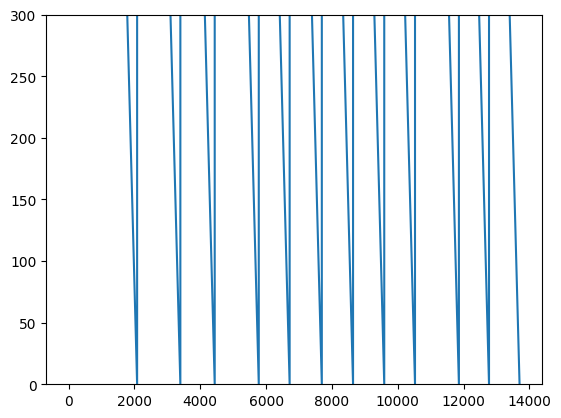

In [34]:
# Note: it is better to drop those time series where all samples all considered anomalies due to very high margins

plt.plot(df["label"])
plt.ylim(0, margin)
plt.show()

# Machine learning: testing phase

## Dataset preprocessing for machine learning models

In this section, RUL labels are converted to binary labels (`0/1`, namely `not_fault/fault`) in order to perform classification instead of regression.

For the `AutoEncoder` model, the dataset is partitioned such that the training set does not contain faults or samples which anticipate a fault. In other words, each sample must be compliant with the `good_samples_thr` threshold.

We basically need an entire section of dataset where faults are not present.

In [35]:
def build_dataset_for_ml_model(df, training_columns, split_size=0.75, as_list=False, ae=False):
    dfs = []
    df_main = df[training_columns]
    fault_indexes = df_main.index[df_main["label"] == 0].tolist() # list of indexes representing faults
    good_samples_thr = margin * 2
    
    previous = 0
    for fi in fault_indexes:
        dfs.append(df_main.iloc[previous:fi+1, :])
        previous = fi + 1
    
    rnd_list = list(range(len(dfs)))
    
    # If split_size is 1, there will be no val/test set
    train_size = floor(len(dfs) * split_size)
    train_index = rnd_list[:train_size]
    test_index = rnd_list[train_size:]
    train_rul = []
    test_rul = []
    
    if not as_list:
        first = True
        for ti in train_index:
            if not ae:
                to_concat = dfs[ti].copy()
            else:
                to_concat = dfs[ti][dfs[ti]["label"] >= good_samples_thr].copy()
            if first:
                training_set = to_concat
                first = False
            else:
                training_set = pd.concat([training_set, to_concat])

        first = True
        for ti in test_index:
            to_concat = dfs[ti].copy()
            if first:
                test_set = to_concat
                first = False
            else:
                test_set = pd.concat([test_set, to_concat])
        
        train_rul = training_set['label'].tolist()
        if split_size < 1:
            test_rul = test_set['label'].tolist()
        
        training_set['label'] = (training_set['label'] >= margin).map({True: 1, False: 0})
        if split_size < 1:
            test_set['label'] = (test_set['label'] >= margin).map({True: 1, False: 0})

        training_set = training_set.to_numpy()
        if split_size < 1:
            test_set = test_set.to_numpy()
        
    else:
        first = True
        for ti in train_index:
            if not ae:
                to_concat = dfs[ti].copy()
            else:
                to_concat = dfs[ti][dfs[ti]["label"] >= good_samples_thr].copy()
            if first:
                training_set = [to_concat]
                first = False
            else:
                training_set.append(to_concat)
                
        first = True
        for ti in test_index:
            to_concat = dfs[ti].copy()
            if first:
                test_set = [to_concat]
                first = False
            else:
                test_set.append(to_concat)
        
        for t in training_set:
            train_rul = train_rul + t['label'].tolist()
            t['label'] = (t['label'] >= margin).map({True: 1, False: 0})
        if split_size < 1:
            for t in test_set:
                test_rul = test_rul + t['label'].tolist()
                t['label'] = (t['label'] >= margin).map({True: 1, False: 0})
    if split_size < 1:
        return training_set, test_set
    return training_set

## Cost model for threshold optimization and performance evaluation

In [36]:
all_perf = []

In [37]:
BASE_FP = 0.2
BASE_FN = 1

def false_positive_cost(i, is_fault, fault_found):
    return BASE_FP

def false_negative_cost(i, is_fault, fault_found):
    if not fault_found:
        for j in range(1, margin + 1):
            if i + j < is_fault.shape[0] and not is_fault[i + j] or i + j >= is_fault.shape[0]:
                return (margin + 1 - j) * BASE_FN
    else:
        return 0

In [38]:
def threshold_optimization(signal, rul, start, end, n_steps):
    best_cost = sys.maxsize
    best_thr = -1
    all_cost = []
    all_thr = []
    is_fault = (rul == 0)
    
    for thr in np.linspace(start, end, n_steps):
        tmp_cost = 0
        fault_found = False
        for i in range(signal.shape[0]):
            if is_fault[i] and signal[i] >= thr:
                fault_found = True
            if not is_fault[i]:
                fault_found = False
            if not is_fault[i] and signal[i] >= thr:
                tmp_cost += false_positive_cost(i, is_fault, fault_found)
            elif is_fault[i] and signal[i] <= thr:
                tmp_cost += false_negative_cost(i, is_fault, fault_found)
        if tmp_cost < best_cost:
            best_thr = thr
            best_cost = tmp_cost
        all_cost.append(tmp_cost)
        all_thr.append(thr)

    return best_cost, best_thr, all_cost, all_thr

In [39]:
def performance_evaluation(signal, thr, rul):
    fp, fn, tp, tot_p = 0, 0, 0, 0
    cost = 0
    alarm = (signal >= thr)
    anticipation = []
    is_fault = (rul == 0)
    
    fault_found = False
    for i in range(len(rul)):
        if i > 0 and is_fault[i] and not is_fault[i - 1]:
            tot_p += 1
            start = i
        if is_fault[i] and not fault_found and alarm[i]:
            tp += 1
            fault_found = True
            anticipation.append((margin - 1) - (i - start))
        if (i < len(rul) - 1 and is_fault[i] and not is_fault[i + 1] and not fault_found) or (i == len(rul) - 1 and not fault_found):
            fn += 1 
        if is_fault[i] and signal[i] <= thr:
            cost += false_negative_cost(i, is_fault, fault_found)
        if not is_fault[i]:
            fault_found = False
            if alarm[i]:
                fp += 1
                cost += false_positive_cost(i, is_fault, fault_found)
        
    tot_a = sum(anticipation) / 10
    if sum(anticipation) > 0:
        mean_a = mean(anticipation) / 10
    else:
        mean_a = 0
    
    return [cost, mean_a, tp, fn, fp]

## Baseline: raw signal pre-anomaly detection

In [40]:
features_raw = [
 'Ax',
 'Ax_diff',
 'Ax_mean_w5',
 'Ax_std_w5',
 'Ax_min_w5',
 'Ax_max_w5',
 'Ax_mean_w10',
 'Ax_std_w10',
 'Ax_min_w10',
 'Ax_max_w10',
 'Ax_mean_w15',
 'Ax_std_w15',
 'Ax_min_w15',
 'Ax_max_w15',
 'Ax_mean_w20',
 'Ax_std_w20',
 'Ax_min_w20',
 'Ax_max_w20',
 'differencing_Ax',
 'differencing_Ax_diff',
 'differencing_Ax_mean_w5',
 'differencing_Ax_std_w5',
 'differencing_Ax_min_w5',
 'differencing_Ax_max_w5',
 'differencing_Ax_mean_w10',
 'differencing_Ax_std_w10',
 'differencing_Ax_min_w10',
 'differencing_Ax_max_w10',
 'differencing_Ax_mean_w15',
 'differencing_Ax_std_w15',
 'differencing_Ax_min_w15',
 'differencing_Ax_max_w15',
 'differencing_Ax_mean_w20',
 'differencing_Ax_std_w20',
 'differencing_Ax_min_w20',
 'differencing_Ax_max_w20',
]

for seed in seeds:
    for feature in features_raw:
        
        f = results_path + "raw_signal-" + feature + "-s" + str(seed) + "-p0"
        with open(f, "rb") as file:
            _, _, _, best_cost_raw, best_thr_raw, _, _, _ = pickle.load(file)
        
        training_columns = [feature, "label"]
        test_set_raw = build_dataset_for_ml_model(df, training_columns=training_columns, split_size=1)
        
        test_raw_signal, test_raw_rul = -test_set_raw[:, 0], test_set_raw[:, -1]
        
        t = threshold_path + "raw_signal-" + feature + "-s" + str(seed) + "-p0"
        to_serialize = test_raw_signal, best_thr_raw, test_raw_rul
        with open(t, "wb") as file:
            pickle.dump(to_serialize, file)
         
        test_perf_raw = performance_evaluation(test_raw_signal, best_thr_raw, test_raw_rul)
        all_perf.append(["raw_signal", seed, feature, {}, "0"] + test_perf_raw)

## Autoencoders

In [41]:
params_ae = [{"hidden_ae": [16, 8, 2, 8, 16]}, 
             {"hidden_ae": [64, 24, 9, 24, 64]}, 
             {"hidden_ae": [128, 56, 18, 56, 128]}]

for seed in seeds:
    for columns in features:
        for params_idx, params in enumerate(params_ae):
            
            ae = keras.models.load_model(models_path + "autoencoder" + "-" + columns + "-s" + str(seed) + "-p" + str(params_idx))
            f = results_path + "autoencoder-" + columns + "-s" + str(seed) + "-p" + str(params_idx)
            with open(f, "rb") as file:
                training_columns, _, _, best_cost_ae, best_thr_ae, _, _, _ = pickle.load(file)
            
            test_set_ae = build_dataset_for_ml_model(df, training_columns=training_columns, split_size=1)
            
            test_preds_ae = ae.predict(test_set_ae[:, :-1])
            
            test_signal_ae = pd.Series(data=np.sum(np.square(test_preds_ae - test_set_ae[:, :-1]), axis=1))
            test_rul_ae = test_set_ae[:, -1]
            
            t = threshold_path + "autoencoder-" + columns + "-s" + str(seed) + "-p" + str(params_idx)
            to_serialize = test_signal_ae, best_thr_ae, test_rul_ae
            with open(t, "wb") as file:
                pickle.dump(to_serialize, file)
            
            test_perf_ae = performance_evaluation(test_signal_ae, best_thr_ae, test_rul_ae)
            all_perf.append(["autoencoder", seed, columns, params, params_idx] + test_perf_ae)

429/429 [==============================] - 0s 545us/step


## Dense Neural Network

In [42]:
params_mlp = [{"hidden_mlp": []},
              {"hidden_mlp": [32]},
              {"hidden_mlp": [64, 32]}, 
              {"hidden_mlp": [128, 64, 32]}]

for seed in seeds:
    for columns in features:
        for params_idx, params in enumerate(params_mlp):
            mlp = keras.models.load_model(models_path + "mlp" + "-" + columns + "-s" + str(seed) + "-p" + str(params_idx))
            f = results_path + "mlp-" + columns + "-s" + str(seed) + "-p" + str(params_idx)
            with open(f, "rb") as file:
                training_columns, _, _, best_cost_mlp, best_thr_mlp, _, _, _ = pickle.load(file)
            
            test_set_mlp = build_dataset_for_ml_model(df, training_columns=training_columns, split_size=1)
            
            test_preds_mlp = mlp.predict(test_set_mlp[:, :-1]).ravel()
            
            test_signal_mlp =  pd.Series(data=(1 - test_preds_mlp))
            test_rul_mlp = test_set_mlp[:, -1]
            
            t = threshold_path + "mlp-" + columns + "-s" + str(seed) + "-p" + str(params_idx)
            to_serialize = test_signal_mlp, best_thr_mlp, test_rul_mlp
            with open(t, "wb") as file:
                pickle.dump(to_serialize, file)
            
            test_perf_mlp = performance_evaluation(test_signal_mlp, best_thr_mlp, test_rul_mlp)
            all_perf.append(["mlp", seed, columns, params, params_idx] + test_perf_mlp)

429/429 [==============================] - 0s 510us/step


## Convolutional Neural Network

In [43]:
def sliding_window_2D(data, w_len, stride=1):
    # Get shifted tables
    m = len(data)
    lt = [data.iloc[i:m-w_len+i+1:stride, :].values for i in range(w_len)]
    # Reshape to add a new axis
    s = lt[0].shape
    for i in range(w_len):
        lt[i] = lt[i].reshape(s[0], 1, s[1])
    # Concatenate
    wdata = np.concatenate(lt, axis=1)
    return wdata


def sliding_window_by_fault(data, cols, w_len, stride=1):
    l_w, l_r = [], []
    cols.pop()  # remove "label"
    for gdata in data:
        # Apply a sliding window
        tmp_w = sliding_window_2D(gdata[cols], w_len, stride)
        # Build the RUL vector
        tmp_r = gdata['label'].iloc[w_len-1::stride]
        # Store everything
        l_w.append(tmp_w)
        l_r.append(tmp_r)
    res_w = np.concatenate(l_w)
    res_r = np.concatenate(l_r)
    return res_w, res_r

In [44]:
params_cnn = [{"filters": 1, "kernel_size": 3, "hidden": [32], "w_len": 5},
              {"filters": 4, "kernel_size": 3, "hidden": [32], "w_len": 5},
              {"filters": 1, "kernel_size": 5, "hidden": [32], "w_len": 5},
              {"filters": 4, "kernel_size": 5, "hidden": [32], "w_len": 5},
              {"filters": 4, "kernel_size": 5, "hidden": [64, 32], "w_len": 5},
              {"filters": 1, "kernel_size": 3, "hidden": [32], "w_len": 10},
              {"filters": 4, "kernel_size": 3, "hidden": [32], "w_len": 10},
              {"filters": 1, "kernel_size": 5, "hidden": [32], "w_len": 10},
              {"filters": 4, "kernel_size": 5, "hidden": [32], "w_len": 10},
              {"filters": 4, "kernel_size": 5, "hidden": [64, 32], "w_len": 10},
              {"filters": 4, "kernel_size": 7, "hidden": [128, 64, 32], "w_len": 10}]

In [45]:
for seed in seeds:
    for columns in features:
        for params_idx, params in enumerate(params_cnn):
            
            cnn = keras.models.load_model(models_path + "conv_nn" + "-" + columns + "-s" + str(seed) + "-p" + str(params_idx))
            f = results_path + "conv_nn-" + columns + "-s" + str(seed) + "-p" + str(params_idx)
            with open(f, "rb") as file:
                training_columns, _, _, best_cost_cnn, best_thr_cnn, _, _, _ = pickle.load(file)
            
            test_set_cnn = build_dataset_for_ml_model(df, training_columns=training_columns, split_size=1, as_list=True)
            ts_sw, ts_sw_r = sliding_window_by_fault(test_set_cnn, training_columns.copy(), params["w_len"])
            
            test_preds_cnn = cnn.predict(ts_sw).ravel()
            
            test_signal_cnn =  pd.Series(data=(1 - test_preds_cnn))
            test_rul_cnn = ts_sw_r
            
            t = threshold_path + "conv_nn-" + columns + "-s" + str(seed) + "-p" + str(params_idx)
            to_serialize = test_signal_cnn, best_thr_cnn, test_rul_cnn
            with open(t, "wb") as file:
                pickle.dump(to_serialize, file)
            
            test_perf_cnn = performance_evaluation(test_signal_cnn, best_thr_cnn, test_rul_cnn)
            all_perf.append(["conv_nn", seed, columns, params, params_idx] + test_perf_cnn)

425/425 [==============================] - 0s 642us/step


## Recurrent Neural Network (LSTM)

In [46]:
def create_dataset_3D(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [47]:
params_rnn = [{"time_steps": 5, "units": 64},
              {"time_steps": 5, "units": 128},
              {"time_steps": 10, "units": 64},
              {"time_steps": 10, "units": 128}]

In [48]:
for seed in seeds:
    for columns in features:
        for params_idx, params in enumerate(params_rnn):
            
            model_lstm = keras.models.load_model(models_path + "lstm" + "-" + columns + "-s" + str(seed) + "-p" + str(params_idx))
            f = results_path + "lstm-" + columns + "-s" + str(seed) + "-p" + str(params_idx)
            with open(f, "rb") as file:
                training_columns, _, _, best_cost_lstm, best_thr_lstm, _, _, _ = pickle.load(file)
            
            test_set_lstm = build_dataset_for_ml_model(df, training_columns=training_columns, split_size=1)
            X_test_lstm, y_test_lstm = create_dataset_3D(test_set_lstm[:, :-1], 
                                           test_set_lstm[:, -1], 
                                           params["time_steps"])            
            test_preds_lstm = model_lstm.predict(X_test_lstm).ravel()
            
            test_signal_lstm =  pd.Series(data=(1 - test_preds_lstm))
            test_rul_lstm = y_test_lstm
            
            t = threshold_path + "lstm-" + columns + "-s" + str(seed) + "-p" + str(params_idx)
            to_serialize = test_signal_lstm, best_thr_lstm, test_rul_lstm
            with open(t, "wb") as file:
                pickle.dump(to_serialize, file)
            
            test_perf_lstm = performance_evaluation(test_signal_lstm, best_thr_lstm, test_rul_lstm)
            all_perf.append(["lstm", seed, columns, params, params_idx] + test_perf_lstm)

428/428 [==============================] - 1s 1ms/step


## Recurrent Neural Network (GRU)

In [49]:
for seed in seeds:
    for columns in features:
        for params_idx, params in enumerate(params_rnn):
            
            model_gru = keras.models.load_model(models_path + "gru" + "-" + columns + "-s" + str(seed) + "-p" + str(params_idx))
            f = results_path + "gru-" + columns + "-s" + str(seed) + "-p" + str(params_idx)
            with open(f, "rb") as file:
                training_columns, _, _, best_cost_gru, best_thr_gru, _, _, _ = pickle.load(file)
            
            test_set_gru = build_dataset_for_ml_model(df, training_columns=training_columns, split_size=1)
            X_test_gru, y_test_gru = create_dataset_3D(test_set_gru[:, :-1], 
                                           test_set_gru[:, -1], 
                                           params["time_steps"])            
            test_preds_gru = model_gru.predict(X_test_gru).ravel()
            
            test_signal_gru =  pd.Series(data=(1 - test_preds_gru))
            test_rul_gru = y_test_gru
            
            t = threshold_path + "gru-" + columns + "-s" + str(seed) + "-p" + str(params_idx)
            to_serialize = test_signal_gru, best_thr_gru, test_rul_gru
            with open(t, "wb") as file:
                pickle.dump(to_serialize, file)
            
            test_perf_gru = performance_evaluation(test_signal_gru, best_thr_gru, test_rul_gru)
            all_perf.append(["gru", seed, columns, params, params_idx] + test_perf_gru)

428/428 [==============================] - 1s 940us/step


## Recurrent Neural Network (BiLSTM)

In [50]:
for seed in seeds:
    for columns in features:
        for params_idx, params in enumerate(params_rnn):
            
            model_bilstm = keras.models.load_model(models_path + "bilstm" + "-" + columns + "-s" + str(seed) + "-p" + str(params_idx))
            f = results_path + "bilstm-" + columns + "-s" + str(seed) + "-p" + str(params_idx)
            with open(f, "rb") as file:
                training_columns, _, _, best_cost_bilstm, best_thr_bilstm, _, _, _ = pickle.load(file)
            
            test_set_bilstm = build_dataset_for_ml_model(df, training_columns=training_columns, split_size=1)
            X_test_bilstm, y_test_bilstm = create_dataset_3D(test_set_bilstm[:, :-1], 
                                           test_set_bilstm[:, -1], 
                                           params["time_steps"])            
            test_preds_bilstm = model_bilstm.predict(X_test_bilstm).ravel()
            
            test_signal_bilstm =  pd.Series(data=(1 - test_preds_bilstm))
            test_rul_bilstm = y_test_bilstm
            
            t = threshold_path + "bilstm-" + columns + "-s" + str(seed) + "-p" + str(params_idx)
            to_serialize = test_signal_bilstm, best_thr_bilstm, test_rul_bilstm
            with open(t, "wb") as file:
                pickle.dump(to_serialize, file)
            
            test_perf_bilstm = performance_evaluation(test_signal_bilstm, best_thr_bilstm, test_rul_bilstm)
            all_perf.append(["bilstm", seed, columns, params, params_idx] + test_perf_bilstm)

428/428 [==============================] - 1s 2ms/step


## Analysis over the test set

In [51]:
df_res = pd.DataFrame(all_perf, columns=["model", "seed", "columns", "params", "params_idx", "cost", "anticipation", "detected_faults", "missed_faults", "false_alarms"])
df_res.to_csv("testing_summary_" + str(margin) + ".csv")